In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from matplotlib.font_manager import FontProperties
%matplotlib inline

In [3]:
import numpy as np
def calc_equb_price(beta):
    A = np.atleast_2d([[(beta-1)*6, (beta-1)*2],[-2*beta-1, -6]]);
    B = np.atleast_2d([[(1-beta)*6],[6]]);
    return np.dot(np.linalg.pinv(A), -B)
def calc_profits(x):
    A = np.atleast_2d([[-3, -2],[-1, -3]])
    B = np.atleast_2d([[6],[6]])
    demand = np.dot(A,x) + B
    x_diag = np.diag(x[:,0])
    return np.dot(x_diag, demand)

def get_price_stats(price):
    profit = calc_profits(price)
    social_welfare = np.sum(profit)
    return profit, social_welfare

def get_beta_stats(beta):
    price = calc_equb_price(beta)
    profit, social_welfare = get_price_stats(price)
    return price, profit, social_welfare

In [4]:
betas = np.linspace(0,1, num = 1000)
sws = np.empty(1000)
profits = np.empty((1000,2))
prices = np.empty((1000,2))
for i in range(1000):
    beta = betas[i]
    x,pi,sw = get_beta_stats(beta)
    sws[i] = sw
    profits[i] = pi[:,0]
    prices[i] = x[:,0]
    


<function matplotlib.pyplot.show>

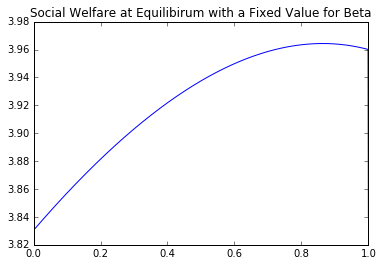

In [5]:
plt.figure()
plt.plot(betas, sws)
plt.title('Social Welfare at Equilibirum with a Fixed Value for Beta')
plt.show

In [6]:
s = 150
lin = np.linspace(0,1,s)
profits = np.empty((s**2, 2))
prices = np.empty((s**2, 2))
sws = np.empty(s**2)
for i in range(s):
    for j in range(s):
        x = np.atleast_2d([[lin[i]],[lin[j]]])
        pi, sw =  get_price_stats(x)
        profits[s*i+j] = pi[:,0]
        prices[s*i+j] = x[:,0]
        sws[s*i+j] = sw

Max profit:  3.99995495698


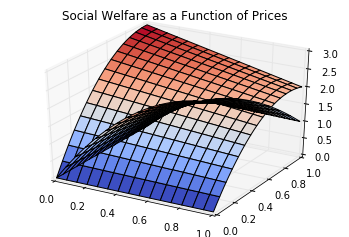

In [7]:
import matplotlib as m
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = prices[:,0].reshape(s,s)
Y = prices[:,1].reshape(s,s)
Z1 = profits[:,0].reshape(s,s)
Z2 = profits[:,1].reshape(s,s)
print 'Max profit: ', max(sws)
ax.plot_surface(X,Y,Z1, cmap=m.cm.coolwarm)
ax.plot_surface(X,Y,Z2, cmap=m.cm.coolwarm)
plt.title('Social Welfare as a Function of Prices')
plt.show()

Max Social Welfare:  3.99995495698


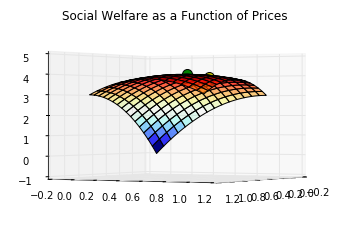

In [8]:
#profits
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = prices[:,0].reshape(s,s)
Y = prices[:,1].reshape(s,s)
Z = sws.reshape(s,s)
print 'Max Social Welfare: ', max(sws)
theCM = m.cm.get_cmap()
theCM._init()
alphas = np.abs(np.linspace(-1.0, 1.0, theCM.N))
theCM._lut[:-3,-1] = alphas
ax.plot_surface(X,Y,Z, cmap=theCM, zorder=1)
ax.scatter([.66],[.66], [4], c='g', s=100, zorder=10)
ax.scatter([12.0/17],[15.0/17], [3.83], c='y', s=100, zorder=10)

ax.view_init(0,30)
plt.title('Social Welfare as a Function of Prices')
plt.show()

In [58]:
def dynamics(x, t):
    #check that values of x are within bounds(prices>=0, 0<=beta<=1)
    #x[0] = max(0,x[0])
    #x[1] = max(0,x[1])
    #x[2] = max(0,x[2])
    #x[2] = min(1,x[2])
    
    c = 0.5
    x = np.atleast_2d(x).T
    x_dot = np.empty((3,1))
    print x
    #calc price dots
    beta = x[2]
    A = np.atleast_2d([[(beta-1.0)*6.0, (beta-1.0)*2.0],[-2.*(beta-1), -6]]);
    B = np.atleast_2d([[(1-beta)*6.0],[6.0]])
    temp = np.dot(A,x[0:2]).reshape(2,1)
    x_dot[0:2] = temp + B
    
    #calc beta_dot
    A_super = np.atleast_2d([[-c*6, (-3*c + 2*beta)],[(-3*c + 2*beta), -c*6]])
    B_super = np.atleast_2d([[c*6],[c*6]])
    temp = np.dot(A_super,x[0:2]).reshape(2,1)
    x_s = temp + B_super
    pi_1 = x[0]*(-3*x[0] - 2*x[1] + 6)
    if pi_1 == 0:
        x_dot[2] = 0
    else:
        x_dot[2] = 0.5*np.dot(x_s.T,x_dot[0:2])/pi_1
    
    #check limits
    if x_dot[0] < 0 and x[0] <= 0:
        x_dot[0] = 0
    if x_dot[1] < 0 and x[1] <= 0:
        x_dot[1] = 0
    if (x_dot[2] < 0 and beta <=0) or (x_dot[2] >0 and beta >= 1):
        x_dot[2] = 0
    #print x_dot.flatten()
    return x_dot.flatten()

#stability check
#assumes input of (3,1) np array
#b_dot = (c(pi_1_dot + pi_2_dot) - b*pi_1_dot)/pi_1
def check_stability(x, c=0.5):
    #don't actually need pi, as it's just a neat little constant factor
    pi_1 = x[0]*(-3*x[0] - 2*x[1] + 6)
    j = np.empty((3,3))
    beta = x[2]
    j[0,0] = 6*(beta - 1)
    j[0,1] = 2*(beta - 1)
    j[0,2] = 6*x[0] + 2*x[1] - 6
    
    j[1,0] = -2*beta - 1
    j[1,1] = -6
    j[1,2] = -2*x[0]
    
    #calc x1 and x2 dots
    A = np.atleast_2d([[(beta-1.0)*6.0, (beta-1.0)*2.0],[-2.*(beta-1), -6]]);
    B = np.atleast_2d([[(1-beta)*6.0],[6.0]])
    temp  = np.dot(A,x[0:2]).reshape(2,1)
    x_dots = temp + B
    
    A_super = np.atleast_2d([[-c*6, (-3*c + 2*beta)],[(-3*c + 2*beta), -c*6]])
    B_super = np.atleast_2d([[c*6],[c*6]])
    temp = np.dot(A_super,x[0:2]).reshape(2,1)
    x_s = temp + B_super
    j[2,0] = x_dots[0]*(-c*6) + j[0,0]*x_s[0] + x_dots[1]*(2*beta - 3*c) + j[1,0]*x_s[1]
    j[2,1] = x_dots[0]*(2*beta - 3*c) + j[0,1]*x_s[0] + x_dots[1]*(-c*6) + j[1,1]*x_s[1]
    j[2,1] = x_dots[0]*(2*x[1]) + j[0,2]*x_s[0] + x_dots[1]*(2*x[0]) + j[1,2]*x_s[1]
    j = j/pi_1
    #matrix is built
    print j
    
    #find eigenvalues
    vals, vecs = np.linalg.eig(j)
    return vals


def display_states(x,t):
    plt.figure()
    fontP = FontProperties()
    fontP.set_size('small')
    x2, = plt.plot(t,x[:,0], color='b', label='x1')
    x1, = plt.plot(t,x[:,1], color='g', label='x2')
    beta, = plt.plot(t,x[:,2], color='r', label='beta')
    plt.legend([x1,x2,beta], prop=fontP)
    eqb_price = np.atleast_2d([x[999,0], x[999,1]]).T
    print 'Ending Prices: ', eqb_price, '\nEnding beta: ', x[99,2]
    profits, sw =  get_price_stats(eqb_price)
    print 'Ending Profits: ', profits, '\nEnding Social Welfare', sw
    plt.show()



[[ 0.]
 [ 0.]
 [ 0.]]
[[  4.39608247e-06]
 [  4.39608247e-06]
 [  0.00000000e+00]]
[[  4.39605670e-06]
 [  4.39606958e-06]
 [  4.99996337e-01]]
[[  2.19804445e-06]
 [  4.39606636e-06]
 [  3.75000916e-01]]
[[  1.09902062e-06]
 [  1.09902062e-06]
 [  0.00000000e+00]]
[[  1.09901901e-06]
 [  1.09901981e-06]
 [  4.99999084e-01]]
[[  5.49510510e-07]
 [  1.09901961e-06]
 [  3.75000229e-01]]
[[  2.74755154e-07]
 [  2.74755154e-07]
 [  0.00000000e+00]]
[[  2.74755054e-07]
 [  2.74755104e-07]
 [  4.99999771e-01]]
[[  1.37377590e-07]
 [  2.74755091e-07]
 [  3.75000057e-01]]
[[  6.86887885e-08]
 [  6.86887885e-08]
 [  0.00000000e+00]]
[[  6.86887823e-08]
 [  6.86887854e-08]
 [  4.99999943e-01]]
[[  3.43443951e-08]
 [  6.86887846e-08]
 [  3.75000014e-01]]
[[  1.71721971e-08]
 [  1.71721971e-08]
 [  0.00000000e+00]]
[[  1.71721967e-08]
 [  1.71721969e-08]
 [  4.99999986e-01]]
[[  8.58609862e-09]
 [  1.71721969e-08]
 [  3.75000004e-01]]
[[  4.29304928e-09]
 [  4.29304928e-09]
 [  0.00000000e+00]]
[[

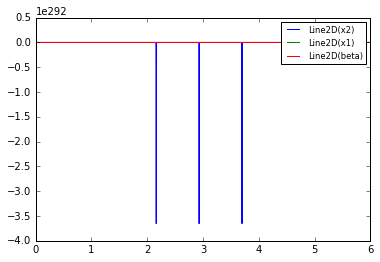

In [59]:
#non-cooperative equilibirum
#x_0 = np.array([12.0/17,15.0/17,0])
#super cooperative equilibrium
#x_0 = np.array([2.0/3,2.0/3,.5])
#other inputs
x_0 = np.array([0,0,0])
t = np.linspace(0.0, 6.0, 1000)

x = odeint(dynamics, x_0, t)
display_states(x,t)

In [53]:
#non-cooperative equilibirum - UNSTABLE!
x_0 = np.array([12.0/17,15.0/17,0.0])
#super cooperative equilibrium
#x_0 = np.array([2.0/3,2.0/3,.5])
#other inputs
#x_0 = np.array([.3,.2,0])
print check_stability(x_0)

[[-4.01388889 -1.33796296  0.        ]
 [-0.66898148 -4.01388889 -0.94444444]
 [ 2.24305556  0.66666667  0.66898148]]
[ 0.66370362 -4.54989404 -3.47260588]


In [109]:
#trying this thing out, but with cooperation going both ways
#expect state vector of formt [x1,x2,beta,alpha]^T
def bilateral_dynamics(x, t):
    #check that values of x are within bounds(prices>=0, 0<=beta<=1)
    #x[0] = max(0,x[0])
    #x[1] = max(0,x[1])
    #x[2] = max(0,x[2])
    #x[2] = min(1,x[2])
    
    c = 0.5
    x = np.atleast_2d(x).T
    x_dot = np.empty((4,1))
    
    #calc price dots
    beta = x[2]
    alpha = x[3]
    A = np.array([[(beta-1.0)*6.0, (beta-1.0)*2.0 - alpha],[(alpha-1)-(2.*beta), -6*(1-alpha)]]).reshape(2,2)
    B = np.atleast_2d([[(1-beta)*6.0],[(1-alpha)*6.0]]).reshape(2,1)
    temp = np.dot(A,x[0:2]).reshape(2,1)
    x_dot[0:2] = temp + B
    
    #calc alpha and beta_dot
    a_temp = np.atleast_2d([[-6, -2],[-2, 0]])
    b_temp = np.atleast_2d([[6],[0]])
    c_temp = np.dot(a_temp,x[0:2]).reshape(2,1) + b_temp
    pi1_dot = np.dot(x_dot[0:2].T, c_temp)
    
    a_temp = np.atleast_2d([[0, -1],[-1, -6]])
    b_temp = np.atleast_2d([[0],[6]])
    c_temp = np.dot(a_temp,x[0:2]).reshape(2,1) + b_temp
    pi2_dot = np.dot(x_dot[0:2].T, c_temp)
    
    pi_1 = x[0]*(-3*x[0] - 2*x[1] + 6)
    pi_2 = x[1]*(-1*x[0] - 3*x[1] + 6)
    
    #set beta
    if pi_1 == 0:
        x_dot[2] = 0
    else:
        x_dot[2] = (c*pi2_dot + (c-beta)*pi1_dot)/pi_1
    #set alpha
    if pi_2 == 0:
        x_dot[3] = 0
    else:
        x_dot[3] = (c*pi1_dot + (c-alpha)*pi2_dot)/pi_2
    
    #check limits
    if x_dot[0] < 0 and x[0] <= 0:
        x_dot[0] = 0
    if x_dot[1] < 0 and x[1] <= 0:
        x_dot[1] = 0
    if (x_dot[2] < 0 and beta <=0) or (x_dot[2] >0 and beta >= 1):
        x_dot[2] = 0
    if (x_dot[3] < 0 and alpha <=0) or (x_dot[3] >0 and alpha >= 1):
        x_dot[3] = 0 
    return x_dot.flatten()

def bilateral_visualization(x,t):
    last = len(x)-1
    plt.figure()
    fontP = FontProperties()
    fontP.set_size('small')
    x2, = plt.plot(t,x[:,0], color='b', label='x1')
    x1, = plt.plot(t,x[:,1], color='g', label='x2')
    beta, = plt.plot(t,x[:,2], color='r', label='beta')
    alpha, = plt.plot(t, x[:,3], color='y', label='alpha')
    plt.legend([x1,x2,beta, alpha], prop=fontP)
    eqb_price = np.atleast_2d([x[last,0], x[last,1]]).T
    print 'Ending Prices: ', eqb_price, '\nEnding beta: ', x[last,2]
    profits, sw =  get_price_stats(eqb_price)
    print 'Ending Profits: ', profits, '\nEnding Social Welfare', sw
    plt.show()





Ending Prices:  [[ 0.69566219]
 [ 0.79999002]] 
Ending beta:  0.289777259517
Ending Profits:  [[ 1.60908988]
 [ 2.32346521]] 
Ending Social Welfare 3.9325550889


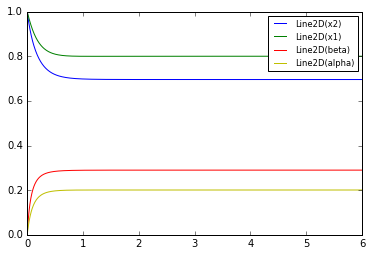

In [113]:
#non-cooperative equilibirum
#x_0 = np.array([12.0/17,15.0/17,0,0])
#super cooperative equilibrium
#x_0 = np.array([2.0/3,2.0/3,.5])
#other inputs
x_0 = np.array([1,1,0,0])
t = np.linspace(0.0, 6.0, 1000)

x = odeint(bilateral_dynamics, x_0, t)
bilateral_visualization(x,t)

In [130]:
#price dynamics, Check if max is possible

def get_equb_stats(alpha, beta):
    A = np.array([[(beta-1.0)*6.0, (beta-1.0)*2.0 - alpha],[(alpha-1)-(2.*beta), -6*(1-alpha)]]).reshape(2,2)
    A_inv = np.linalg.pinv(A)
    B = np.atleast_2d([[(1-beta)*6.0],[(1-alpha)*6.0]]).reshape(2,1)
    x = np.dot(A_inv, -1*B)
    pi_1 = x[0]*(-3*x[0] - 2*x[1] + 6)
    pi_2 = x[1]*(-1*x[0] - 3*x[1] + 6)
    
    return x, pi_1, pi_2


In [ ]:
s = 200
lin = np.linspace(0,1,s)
prices = np.empty((s**2, 2))
coefs = np.empty((s**2, 2))
sws = np.empty(s**2)
for i in range(s):
    for j in range(s):
        alpha = lin[i]
        beta = lin[j]

        x, pi_1, pi_2 = get_equb_stats(alpha, beta)
        x = np.atleast_2d([[lin[i]],[lin[j]]])
        pi, sw =  get_price_stats(x)
        coefs[s*i+j] = [alpha, beta]
        sws[s*i+j] = pi_1 + pi_2
        #if (pi_1 + pi_2) == 4.0:
            #print pi_1, pi_2
            #print alpha, beta, x

0.0 0.0
0.0 0.00502512562814
0.0 0.0100502512563
0.0 0.0150753768844
0.0 0.0201005025126
0.0 0.0251256281407
0.0 0.0301507537688
0.0 0.035175879397
0.0 0.0402010050251
0.0 0.0452261306533
0.0 0.0502512562814
0.0 0.0552763819095
0.0 0.0603015075377
0.0 0.0653266331658
0.0 0.070351758794
0.0 0.0753768844221
0.0 0.0804020100503
0.0 0.0854271356784
0.0 0.0904522613065
0.0 0.0954773869347
0.0 0.100502512563
0.0 0.105527638191
0.0 0.110552763819
0.0 0.115577889447
0.0 0.120603015075
0.0 0.125628140704
0.0 0.130653266332
0.0 0.13567839196
0.0 0.140703517588
0.0 0.145728643216
0.0 0.150753768844
0.0 0.155778894472
0.0 0.160804020101
0.0 0.165829145729
0.0 0.170854271357
0.0 0.175879396985
0.0 0.180904522613
0.0 0.185929648241
0.0 0.190954773869
0.0 0.195979899497
0.0 0.201005025126
0.0 0.206030150754
0.0 0.211055276382
0.0 0.21608040201
0.0 0.221105527638
0.0 0.226130653266
0.0 0.231155778894
0.0 0.236180904523
0.0 0.241206030151
0.0 0.246231155779
0.0 0.251256281407
0.0 0.256281407035
0.0 0.2

Max profit:  4.0


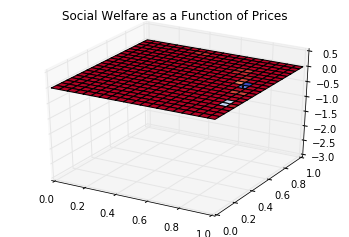

In [121]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = coefs[:,0].reshape(s,s)
Y = coefs[:,1].reshape(s,s)
Z = sws.reshape(s,s)
print 'Max profit: ', max(sws)
ax.plot_surface(X,Y,Z, cmap=m.cm.coolwarm)
plt.title('Social Welfare as a Function of Prices')
plt.show()